In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:

spark = SparkSession.builder.getOrCreate()
features = spark.read.csv("file:///root/lol/spark_feature.csv", header=True, inferSchema=True)
features = features.limit(10000)


train_data, test_data = features.randomSplit([0.7, 0.3], seed=42)

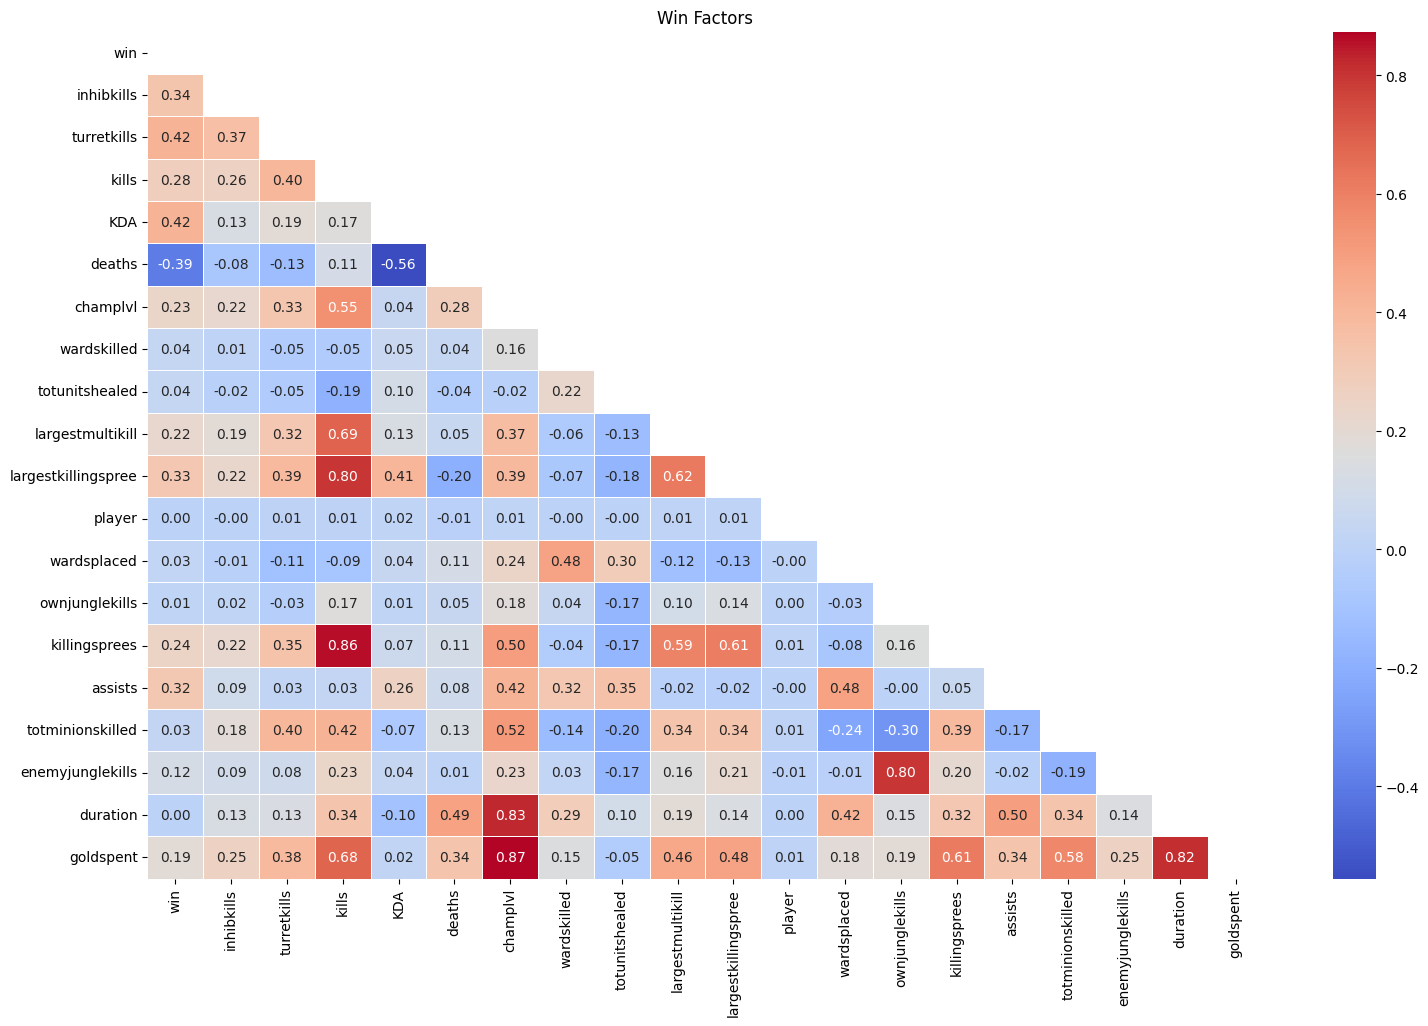

In [11]:

df = features.toPandas()


df_fac = df[['win', 'inhibkills', 'turretkills', 'kills', 'KDA', 'deaths', 'champlvl', 'wardskilled', 'totunitshealed', 'largestmultikill', 'largestkillingspree', 'player', 'wardsplaced', 'ownjunglekills', 'killingsprees', 'assists', 'totminionskilled', 'enemyjunglekills', 'duration', 'goldspent' ]]


mask = np.zeros_like(df_fac.corr(), dtype= bool)
mask[np.triu_indices_from(mask)]= True

# Create a heatmap
plt.figure(figsize=(18,11))
sns.heatmap(df_fac.corr(), cmap= 'coolwarm', annot= True, fmt= '.2f', linewidths= .5, mask= mask)
plt.title('Win Factors')
plt.show()

In [12]:

feature_columns = [col for col in features.columns if col != "win"]

vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data_transformed = vector_assembler.transform(train_data)
test_data_transformed = vector_assembler.transform(test_data)

lr = LogisticRegression(featuresCol="features", labelCol="win")

# Define a parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1, 10, 100]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

# Define cross-validation
cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="win", metricName="areaUnderROC"),
    numFolds=3
)

cv_model = cross_validator.fit(train_data_transformed)

lr_best_model = cv_model.bestModel


2023-07-13 21:27:46,913 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2023-07-13 21:27:46,914 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [13]:
print("Best Regularization Parameter (C): ", lr_best_model._java_obj.getRegParam())
print("Best Elastic Net Mixing Parameter (penalty): ", lr_best_model._java_obj.getElasticNetParam())

predictions = lr_best_model.transform(test_data_transformed)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="win", metricName="areaUnderROC")
lr_roc_auc = evaluator.evaluate(predictions)
print("ROC AUC with best parameters: ", lr_roc_auc)


evaluator_precision = MulticlassClassificationEvaluator(labelCol="win", predictionCol="prediction", metricName="weightedPrecision")
lr_precision = evaluator_precision.evaluate(predictions)
print("Precision with best parameters: ", lr_precision)

Best Regularization Parameter (C):  0.01
Best Elastic Net Mixing Parameter (penalty):  0.0
ROC AUC with best parameters:  0.9463574478598049
Precision with best parameters:  0.8806546587523949


In [14]:
feature_weights = lr_best_model.coefficients.toArray()
coef_table = pd.DataFrame(list(zip(feature_columns, abs(feature_weights))), columns=['Attributes', 'Coefficient'])

coef_table_sorted = coef_table.sort_values(by=['Coefficient'], ascending=False)

print(coef_table_sorted.head(20))

coef_table_sorted.to_csv('feature_weight/lr_feature_weights.csv', index=False)

             Attributes  Coefficient
40           inhibkills     1.222575
15           pentakills     0.520730
39          turretkills     0.519675
14          quadrakills     0.399867
46             champlvl     0.282499
6                deaths     0.277219
53                  KDA     0.169827
51             seasonid     0.144938
9      largestmultikill     0.136322
7               assists     0.114736
13          triplekills     0.093635
50           firstblood     0.067706
27       totunitshealed     0.049650
10        killingsprees     0.047808
12          doublekills     0.029010
47          pinksbought     0.026400
44     enemyjunglekills     0.020213
8   largestkillingspree     0.018710
5                 kills     0.016580
43       ownjunglekills     0.010851


### 随机森林

In [15]:

feature_columns = [col for col in features.columns if col != "win"]

vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data_transformed = vector_assembler.transform(train_data)
test_data_transformed = vector_assembler.transform(test_data)

rf = RandomForestClassifier(featuresCol="features", labelCol="win")

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

cross_validator = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="win", metricName="areaUnderROC"),
    numFolds=3
)

cv_model = cross_validator.fit(train_data_transformed)

rf_best_model = cv_model.bestModel



2023-07-13 21:29:31,640 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
2023-07-13 21:29:31,808 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
2023-07-13 21:29:31,961 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1230.1 KiB
2023-07-13 21:29:32,099 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1264.8 KiB
2023-07-13 21:29:32,233 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1172.5 KiB
2023-07-13 21:29:32,348 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1186.7 KiB
2023-07-13 21:29:36,375 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1482.3 KiB
2023-07-13 21:29:37,053 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
2023-07-13 21:29:37,847 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 2.8 MiB
2023-07-13 21:29:38,843 WARN scheduler.DAGScheduler: Broadcas

In [16]:
print("Best Number of Trees: ", rf_best_model._java_obj.getNumTrees())
print("Best Max Depth: ", rf_best_model._java_obj.getMaxDepth())

predictions = rf_best_model.transform(test_data_transformed)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="win", metricName="areaUnderROC")
rf_roc_auc = evaluator.evaluate(predictions)
print("ROC AUC with best parameters: ", rf_roc_auc)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="win", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = evaluator_precision.evaluate(predictions)
print("Precision with best parameters: ", rf_precision)

Best Number of Trees:  100
Best Max Depth:  20


2023-07-13 21:33:07,323 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 9.8 MiB


ROC AUC with best parameters:  0.9453666065246216


2023-07-13 21:33:08,978 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 9.8 MiB


Precision with best parameters:  0.8647754769344964


In [17]:
feature_importances = rf_best_model.featureImportances.toArray()

importance_table = pd.DataFrame(list(zip(feature_columns, abs(feature_importances))), columns=['Attributes', 'Coefficient'])

importance_table_sorted = importance_table.sort_values(by=['Coefficient'], ascending=False)
print(importance_table_sorted.head(20))

importance_table_sorted.to_csv('feature_weight/rf_feature_weights.csv', index=False)

                Attributes  Coefficient
53                     KDA     0.201368
30            dmgtoturrets     0.071799
39             turretkills     0.058300
6                   deaths     0.054980
40              inhibkills     0.045777
7                  assists     0.037882
37              goldearned     0.029552
29                dmgtoobj     0.028695
52                duration     0.021223
11  longesttimespentliving     0.020182
8      largestkillingspree     0.019128
33             totdmgtaken     0.018809
0                       id     0.017315
34           magicdmgtaken     0.017243
38               goldspent     0.016944
41        totminionskilled     0.016431
35            physdmgtaken     0.015842
36            truedmgtaken     0.014988
44        enemyjunglekills     0.014482
5                    kills     0.013615


### Xgboost
Xgboost does not support the distributed version of PySpark, so we need to use Pandas to train the model locally

In [18]:
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

feature_columns = [col for col in train_data_pd.columns if col != "win"]

X_train = train_data_pd[feature_columns]
y_train = train_data_pd["win"]
X_test = test_data_pd[feature_columns]
y_test = test_data_pd["win"]

train_data_xgb = xgb.DMatrix(X_train, label=y_train)
test_data_xgb = xgb.DMatrix(X_test, label=y_test)

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [10, 50],
    'subsample': [0.5],
    'gamma': [0.05],
    'booster': ['gbtree', 'dart']
}

grid = GridSearchCV(model, params, verbose=1, cv=3, scoring='roc_auc')

grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best parameters found: ", best_params)

best_model = grid.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'booster': 'dart', 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 500, 'subsample': 0.5}


In [19]:
y_pred = best_model.predict_proba(X_test)[:, 1]

xgb_roc_auc = roc_auc_score(y_test, y_pred)
xgb_precision =  precision_score(y_test, [1 if p >= 0.5 else 0 for p in y_pred])
print('ROC AUC with best parameters: ', xgb_roc_auc)
print('Precision with best parameters: ', xgb_precision)

ROC AUC with best parameters:  0.9667325319799706
Precision with best parameters:  0.8968363136176066


In [20]:
feature_importances = best_model.feature_importances_

importance_table = pd.DataFrame(list(zip(feature_columns, abs(feature_importances))), columns=['Attributes', 'Coefficient'])

importance_table_sorted = importance_table.sort_values(by=['Coefficient'], ascending=False)
print(importance_table_sorted.head(20))

importance_table_sorted.to_csv('feature_weight/xgb_feature_weights.csv', index=False)

                Attributes  Coefficient
53                     KDA     0.150009
40              inhibkills     0.135857
39             turretkills     0.058940
30            dmgtoturrets     0.039774
29                dmgtoobj     0.022315
11  longesttimespentliving     0.021803
22           totdmgtochamp     0.018471
28              dmgselfmit     0.018206
38               goldspent     0.017790
52                duration     0.017357
46                champlvl     0.017092
12             doublekills     0.016476
44        enemyjunglekills     0.016248
37              goldearned     0.016088
27          totunitshealed     0.016075
17             totdmgdealt     0.015911
33             totdmgtaken     0.015703
19        physicaldmgdealt     0.015664
35            physdmgtaken     0.015292
41        totminionskilled     0.015270


In [21]:
# Aggregate scores of different models
scores = pd.DataFrame({"model":["LogisticRegression","RandomForest","XGBoost"],
                       "auc":[lr_roc_auc, rf_roc_auc, xgb_roc_auc],
                       "accuracy": [lr_precision, rf_precision, xgb_precision]})
scores.sort_values(by="auc",ascending=False)
scores.to_csv("feature_weight/model_scores.csv", index=False)
scores

,model,auc,accuracy
0,LogisticRegression,0.946357,0.880655
1,RandomForest,0.945367,0.864775
2,XGBoost,0.966733,0.896836
